#  Деревья. Случайный лес

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def entropy(y):
    size = len(y)

    counts = {}
    for item in y:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    
    return -sum( counts[key] / size* np.log(counts[key] / size) for key in counts)

In [ ]:
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

round(entropy(y), 2)

0.5

In [ ]:
def gini(y):
    size = len(y)
    counts = {}
    for item in y:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    
    return sum((counts[key] / size) * (1 - counts[key] / size) for key in counts)

In [ ]:
Rm = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
Rl = np.array([0, 0, 0, 0, 0, 0, 0, 0])
Rr = np.array([1, 1])
print(round(gini(Rm) - gini(Rl) * Rl.size / Rm.size - gini(Rr) * Rr.size / Rm.size, 2))

0.32


In [ ]:
print(np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])) #просто среднее арифметическое

40.6


In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    thresholds, ginis, threshold_best, gini_best = [], [], None, None
    features = np.unique(feature_vector)

    if feature_type == 'real':
        features = np.sort(features)
        thresholds = features[1:-1]
        
    elif feature_type == 'categorical': 
        thresholds = features
    
    if task == 'regression':
        q = np.vectorize(lambda x: regress(*split_node(x, feature_vector, target_vector, feature_type)))

    if task == 'classification':
        q = np.vectorize(lambda x: classific(*split_node(x, feature_vector, target_vector, feature_type)))
    
    ginis = q(thresholds)
    best = np.argmin(ginis)
    threshold_best, gini_best = thresholds[best], ginis[best]
    
    return thresholds, ginis, threshold_best, gini_best

def classific(*args):
    q_func = lambda l, r: (gini(l) * l.size/ (l.size + r.size) + gini(r) * r.size/ (l.size + r.size))           
    return q_func(*args)


def regress(*args):
    q_func = lambda l, r: (l.size/ (l.size + r.size) * r.var() + r.size / (l.size + r.size)  * r.var())          
    return q_func(*args)
                          
def split_node(t, Rm, y, feature_type):
    if feature_type == 'real':
        mask = (Rm <= t) 
    else:
        mask = (Rm == t)
    return y[np.where(mask)[0]], y[np.where(~mask)[0]]

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [ ]:
thresholds, ginis, threshold_best, gini_best = find_best_split(
    X["MedInc"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

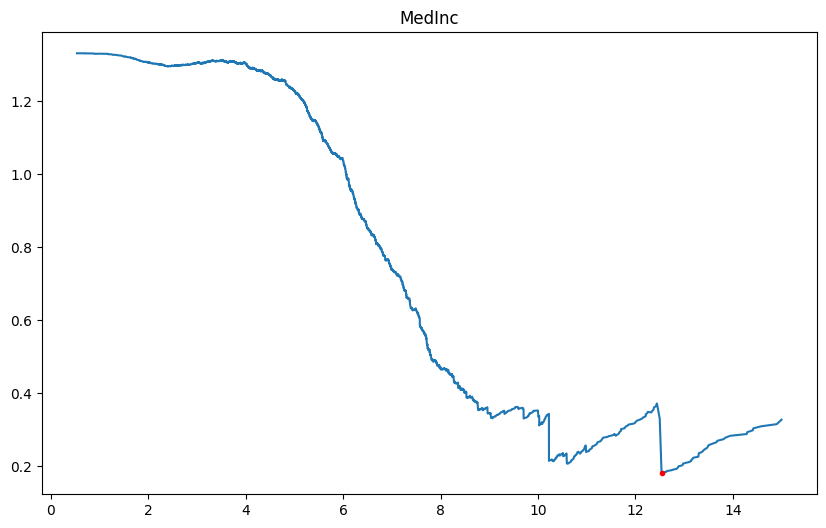

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis)
plt.plot(threshold_best, gini_best, marker='.', color='r')
plt.title("MedInc")
plt.show()

In [ ]:
threshold_best

12.5381

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best: # my best split is searching for minimum gini
                feature_best = feature
                gini_best = gini
                
                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- ( ͡° ͜ʖ ͡°)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else: 
                    raise ValueError
        
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']

        if self._feature_types[node['feature_split']] == 'real':
            lc = x[node['feature_split']] <= node['threshold']
            rc = x[node['feature_split']] > node['threshold']
        
        elif self._feature_types[node['feature_split']] == 'categorical':  
            lc = x[node['feature_split']] == node['category_split']
            rc = x[node['feature_split']] != node['category_split']

        if lc:
            return self._predict_node(x, node['left_child'])
        elif rc:
            return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

In [ ]:
data = pd.read_csv('students.csv', index_col=0)

In [ ]:
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


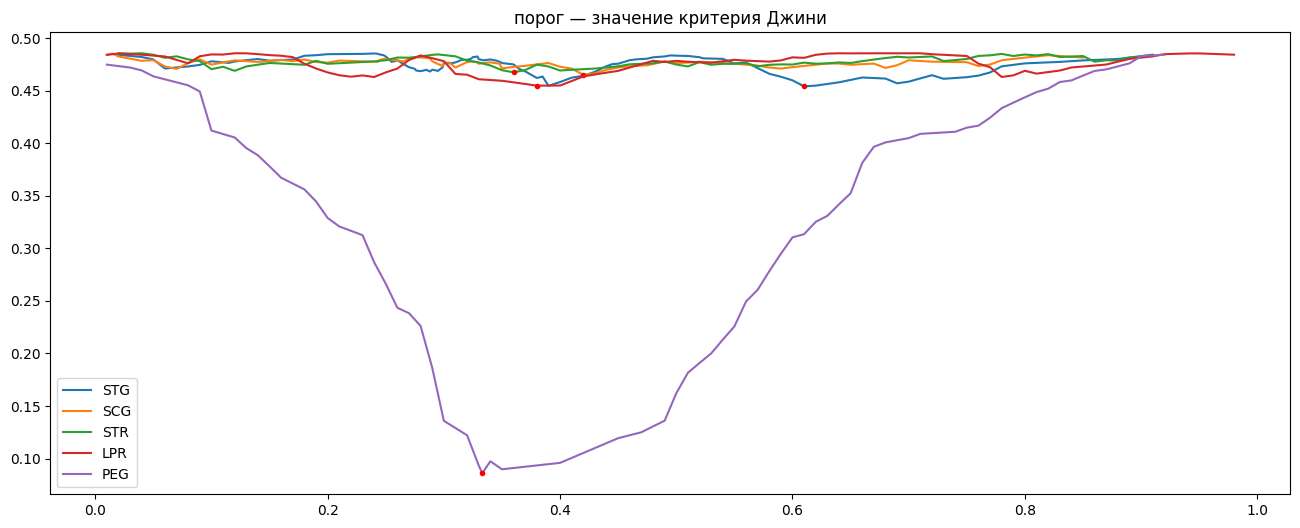

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 6))

for feature in data.iloc[:, :-1].columns:
    thresholds, ginis, threshold_best, variance_best = find_best_split(
        data[feature].to_numpy(), 
        data['UNS'].to_numpy(), 
        task="classification",
        feature_type="real"
    )
    
    sns.lineplot(x=thresholds, y=ginis, label=feature)
    plt.plot(threshold_best, variance_best, marker='.', color='r')

plt.title("порог — значение критерия Джини")
plt.show()

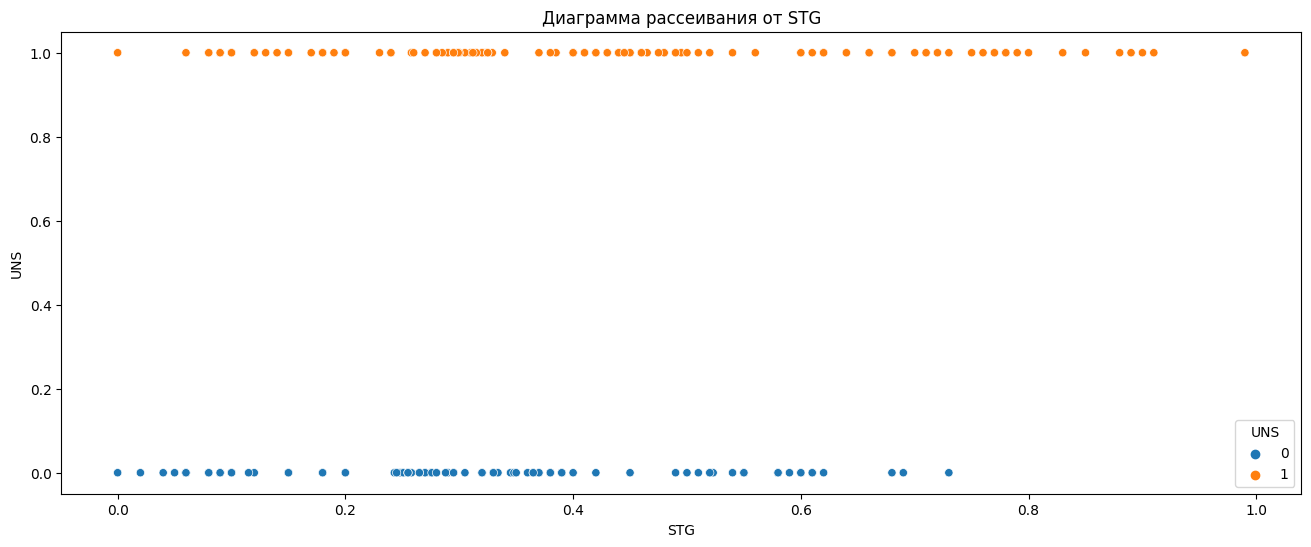

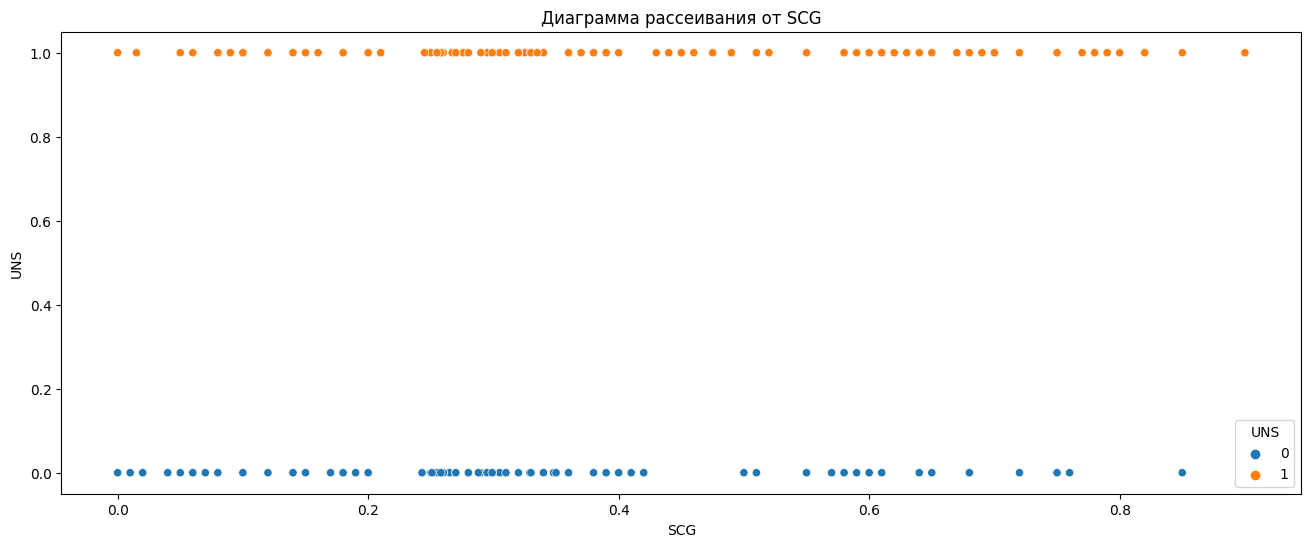

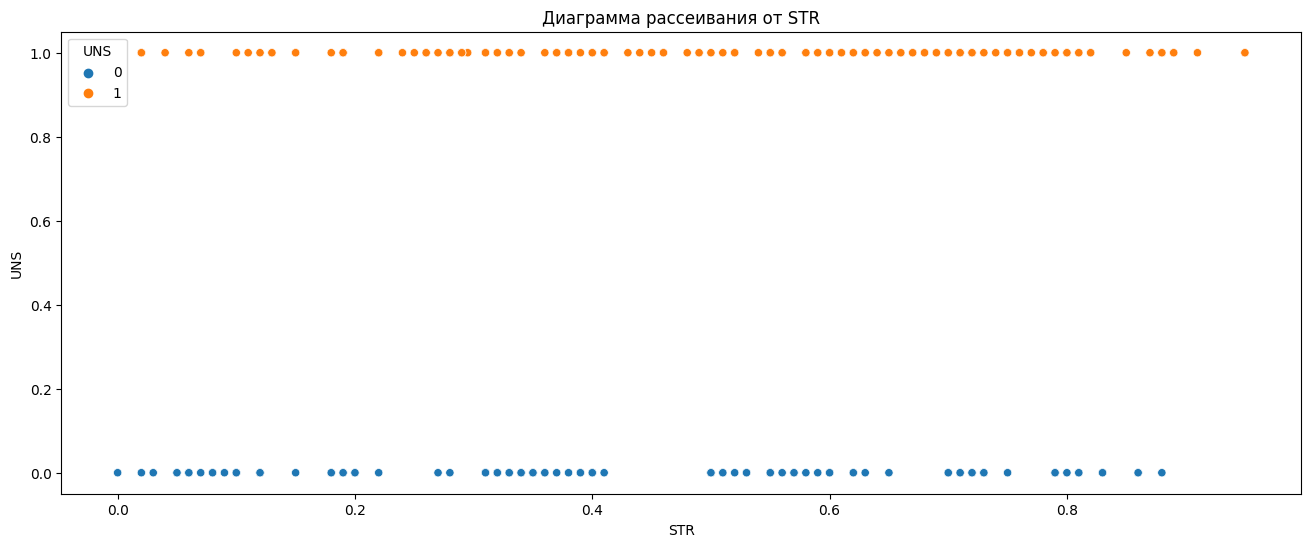

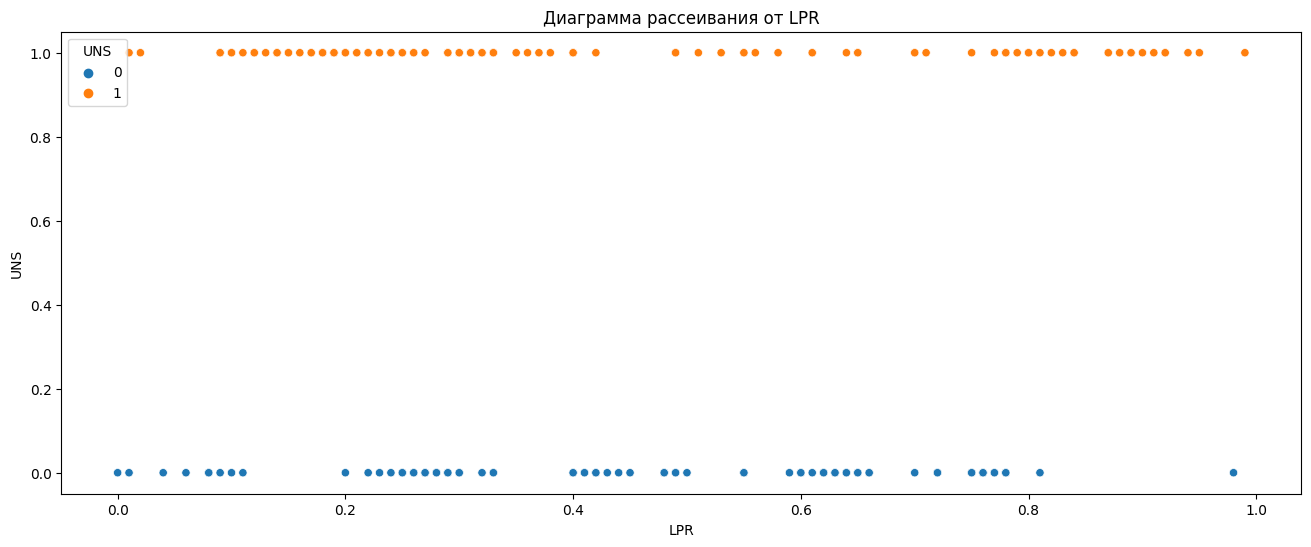

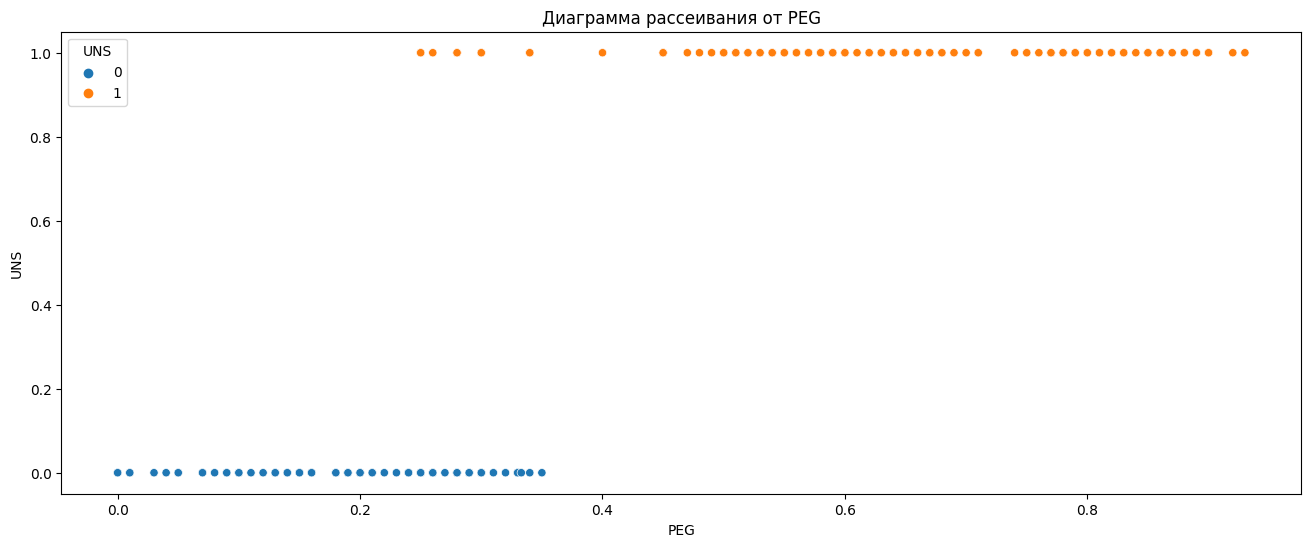

In [ ]:
for feature in data.iloc[:, :-1].columns:
    plt.figure(figsize=(16, 6))
    sns.scatterplot(data=data, x=feature, y='UNS', hue='UNS')
    plt.title(f"Диаграмма рассеивания от {feature}")
plt.show()

## Вывод
1) Из кривых значений критерия Джини самое оптимальное производить деление по признаку PEG

2) Это согласуется с визуальной оценкой, так на диаграмме рассеивания по этому признаку действительно можно подобрать близкий к идеальному порог разделения 

3) Кривая для хороших признаков должна по форме быть похожа на параболу, те иметь какой-то минимум отличимый от "рандомных вариантах распределения по признаку", чем ближе к нулю тем лучше 
(Уменьшаем хаотичночность в данных)

4) Если по признаку деление почти невозможно, те по нему данные неразделимы, то критерий Джини будет высок и кривая  по-своему виду будет близка к горизонтальной прямой 
(Не уменьшаем хаотичночность в данных)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
data = pd.read_csv('agaricus-lepiota.data', header=None).apply(LabelEncoder().fit_transform)
X_train, X_test, y_train, y_test = train_test_split(data.drop(0, axis=1).values, data[0].values, test_size=0.5, random_state=42)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [ ]:
import sys
sys.setrecursionlimit(100000)

In [ ]:
tree = DecisionTree(feature_types=['categorical'] * 22)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test, pred)}')

Accuracy score: 1.0


In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

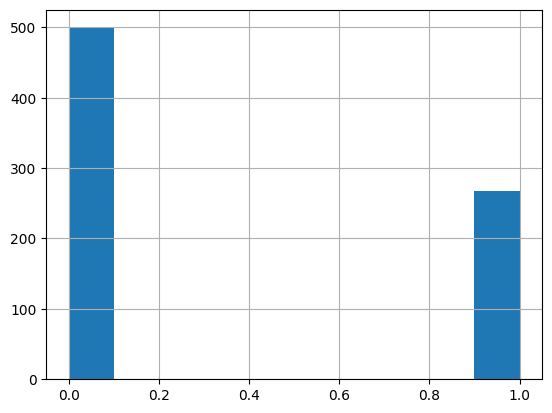

In [ ]:
data['Outcome'].hist()
plt.show()

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
max_depth_arr = np.arange(1, 21, 2)
min_samples_leaf_arr = np.arange(1, 31, 2)

combinations = []
scores = []

for max_depth in max_depth_arr:
    for min_samples_leaf in min_samples_leaf_arr:
        combinations.append((max_depth, min_samples_leaf))
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree = tree.fit(X_train, y_train)
        pred = tree.predict(X_val)
        score = f1_score(y_val, pred)
        scores.append(score)
        
best = np.argmax(scores)       
best_max_depth = combinations[best][0]
best_min_sample_leaves = combinations[best][1]

print('Best parameter combinations: {}'.format(combinations[best]))
print('Best score: {}'.format(max(scores)))

Best parameter combinations: (7, 7)
Best score: 0.7142857142857143


In [ ]:
tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_sample_leaves)
tree = tree.fit(X_train_full, y_train_full)

pred = tree.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, pred),3)}')
print(f'Precision: {round(precision_score(y_test, pred),3)}')
print(f'Recall: {round(recall_score(y_test, pred),3)}')
print(f'AUC ROC: {round(roc_auc_score(y_test, pred),3)}')

Accuracy: 0.693
Precision: 0.549
Recall: 0.625
AUC ROC: 0.677


In [ ]:
bagg_clf = BaggingClassifier(n_estimators=50, random_state=42)
bagg_clf = bagg_clf.fit(X_train_full, y_train_full)

pred = bagg_clf.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, pred),3)}')
print(f'Precision: {round(precision_score(y_test, pred),3)}')
print(f'Recall: {round(recall_score(y_test, pred),3)}')
print(f'AUC ROC: {round(roc_auc_score(y_test, pred),3)}')
print(f'F1-score: {f1_score(y_test, pred)}')

Accuracy: 0.749
Precision: 0.631
Recall: 0.662
AUC ROC: 0.729
F1-score: 0.646341463414634


In [ ]:
from matplotlib import rc_file
from sklearn.model_selection import KFold
np.random.seed(42)

max_depth_arr = np.arange(1, 21, 3)
min_samples_leaf_arr = np.arange(1, 31, 3)

combinations = []
scores = []

kf = KFold(n_splits=4)

for max_depth in max_depth_arr:
    for min_samples_leaf in min_samples_leaf_arr:
        combinations.append((max_depth, min_samples_leaf))
        prom = []
        for train_ind, test_ind in kf.split(X_train_full):
            rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_jobs=-1)
            rf = rf.fit(X_train_full.iloc[train_ind], y_train_full.iloc[train_ind])
            pred = rf.predict(X_train_full.iloc[test_ind])
            prom.append(f1_score(y_train_full.iloc[test_ind], pred))
        scores.append(np.mean(prom))
    
best = np.argmax(scores)       
best_max_depth = combinations[best][0]
best_min_sample_leaves = combinations[best][1]

print('Best parameter combinations: {}'.format(combinations[best]))
print('Best score: {}'.format(max(scores)))

Best parameter combinations: (7, 4)
Best score: 0.6548126496975603


In [ ]:
rf_for_last = RandomForestClassifier(n_estimators=50,max_depth=best_max_depth, min_samples_leaf=best_min_sample_leaves, random_state=42)
rf_for_last = rf_for_last.fit(X_train_full, y_train_full)

pred = rf_for_last.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, pred),3)}')
print(f'Precision: {round(precision_score(y_test, pred),3)}')
print(f'Recall: {round(recall_score(y_test, pred),3)}')
print(f'AUC ROC: {round(roc_auc_score(y_test, pred),3)}')
print(f'F1-score: {f1_score(y_test, pred)}')

Accuracy: 0.753
Precision: 0.642
Recall: 0.65
AUC ROC: 0.729
F1-score: 0.6459627329192547


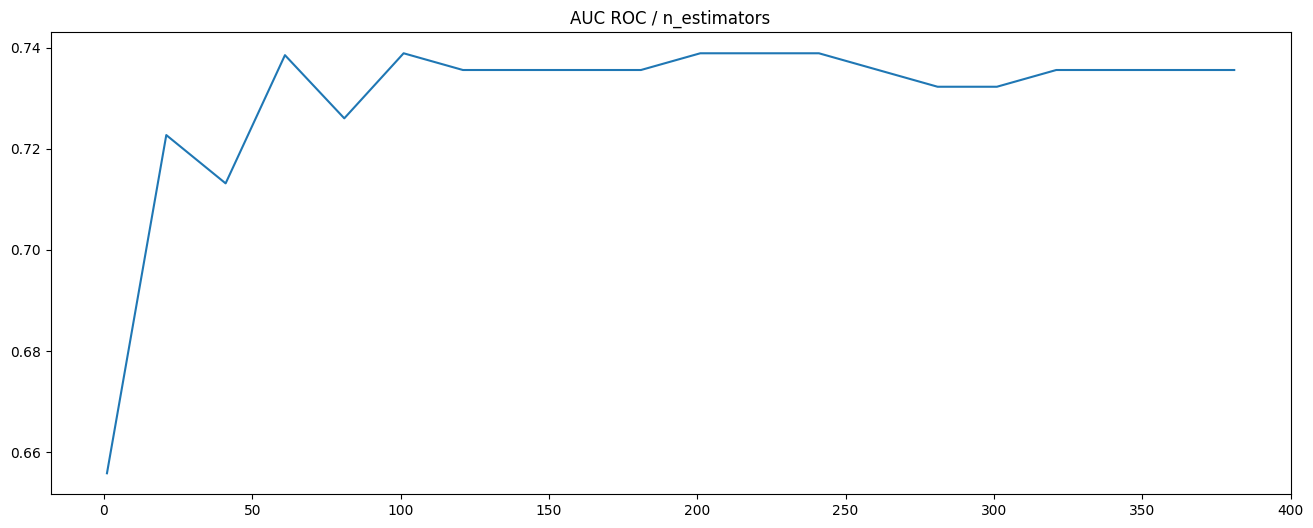

In [ ]:
n_estimator_counter = np.arange(1, 400, 20)
scores = []

for n_estimators in n_estimator_counter:
    rf = RandomForestClassifier(n_estimators=n_estimators,max_depth=best_max_depth, min_samples_leaf=best_min_sample_leaves, random_state=42)
    rf = rf.fit(X_train_full, y_train_full)
    pred = rf.predict(X_test)
    scores.append(roc_auc_score(y_test, pred))
    
plt.figure(figsize=(16, 6))
plt.plot(n_estimator_counter, scores)
plt.title('AUC ROC / n_estimators')
plt.show()

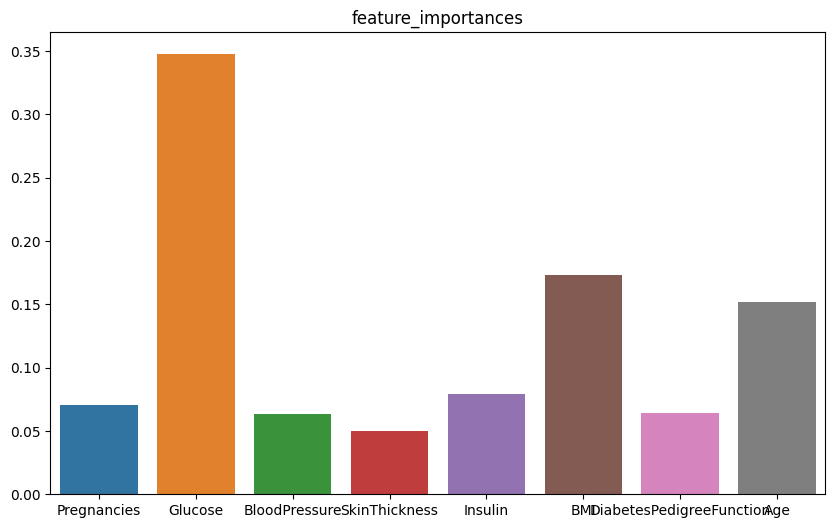

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=rf_for_last.feature_importances_)
plt.title('feature_importances')
plt.show()